# Option Pricing with Variance Gamma Markov Chains

Replication of Konikov-Madan (2002) paper.

We implement:
1. Single VG model: FFT vs Monte Carlo pricing
2. Two-state Markov VG model: FFT vs Monte Carlo pricing
3. Model calibration to synthetic market data
4. PDF comparisons and implied volatility analysis

In [1]:
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import py_vollib_vectorized
from scipy.optimize import minimize

from msvg import (VGParams, calibrate_markov_vg, calibrate_single_vg,
                  fft_call_price, markov_vg_cf, monte_carlo_markov_vg_numba,
                  monte_carlo_single_vg, pdf_from_cf, vg_cf)

plt.style.use("seaborn-v0_8-whitegrid")
%config InlineBackend.figure_format = 'svg'
np.random.seed(42)

## Model Definitions: Variance Gamma (VG) & 2-State Markov Switching

This section outlines the characteristic functions (CF) for the Variance Gamma models, progressing from the standard single-state process to the two-state Markov switching model (Konikov–Madan).

---

### 1. Single-State Variance Gamma (VG)
The VG process is the buildingblock. It's equivalent to a "time-changed" Brownian motion that captures skewness and excess kurtosis (fat tails).

**Characteristic Function (Eq. 5):**
$$
\Phi_{X(t)}(u) = \left(1 - i \theta \nu u + \frac{\sigma^2 \nu}{2} u^2\right)^{-t/\nu}
$$

> **Intuition:** A standard random walk (Brownian motion), but the clock ticks at a random rate determined by a Gamma process. 
> * **High $\nu$:** The clock is very erratic (causing fat tails).
> * **Non-zero $\theta$:** The clock correlates with price direction (causing skew).

---

### 2. Two-State VG Markov Model
This model assumes the market switches between two distinct regimes (e.g., State 0 "Calm" and State 1 "Turbulent"), each governed by its own VG parameters.

**Main Characteristic Function:**
The CF for the log price $X(t)$ combines the base state dynamics with a correction for time spent in the alternative state:

$$
\phi_X(u) = \phi_0(u)^t \cdot g\!\left(\log\frac{\phi_0(u)}{\phi_1(u)}\right)
$$

Where:
* $\phi_0(u), \phi_1(u)$: The standard VG characteristic functions for State 0 and State 1.
* $g(\lambda)$: The Laplace transform of the occupancy time (time spent in State 1).
* $\lambda = \log(\phi_0(u)/\phi_1(u))$: The transform parameter.

> **Intuition:** The asset follows State 0 by default. The function $g(\lambda)$ acts as a "mixer," adjusting the probability distribution based on how likely the market is to jump into (and stay in) State 1 during the life of the option.

### 3. Occupancy Functions & Roots ($g$ and $\eta$)

The function $g(\lambda)$ accounts for the initial probability $p$ of starting in State 0:
$$
g(\lambda) = p \cdot g_0(\lambda) + (1-p) \cdot g_1(\lambda)
$$

**Explicit Solutions for Conditional Laplace Transforms ($g_0, g_1$):**
These represent the discounted time spent in State 1, conditional on the starting state.

$$
\begin{aligned}
g_0(\lambda) &= e^{-(\eta_1(\lambda)+\lambda_{01}) t} \left[ \frac{\eta_2(\lambda)+\lambda_{01}-(\eta_1(\lambda)+\lambda_{01}) e^{-(\eta_2(\lambda)-\eta_1(\lambda)) t}}{\eta_2(\lambda)-\eta_1(\lambda)} \right] \\[1em]
g_1(\lambda) &= \frac{e^{-(\eta_1(\lambda)+\lambda_{01}) t}}{\lambda_{01}} \left[ \frac{\eta_2(\lambda)(\eta_1(\lambda)+\lambda_{01}) e^{-(\eta_2(\lambda)-\eta_1(\lambda)) t}-\eta_1(\lambda)(\eta_2(\lambda)+\lambda_{01})}{\eta_2(\lambda)-\eta_1(\lambda)} \right]
\end{aligned}
$$

**Roots of the Characteristic Equation ($\eta$):**
Derived from solving the Riccati equation associated with the Markov chain:

$$
\eta_{1,2}(\lambda) = \frac{\lambda+\lambda_{10}-\lambda_{01}}{2} \pm \sqrt{\frac{(\lambda+\lambda_{10}-\lambda_{01})^2}{4}+\lambda_{10} \lambda_{01}}
$$

---

### 4. Parameter Glossary (9 parameters total)

#### VG Process Parameters – different in each regime

| State          | Volatility | Kurtosis | Skew / Drift |
|------------------------|------------|----------|--------------|
| **State 0 (Calm)**     | $\sigma_0$ | $\nu_0$  | $\theta_0$   |
| **State 1 (Turbulent)**| $\sigma_1$ | $\nu_1$  | $\theta_1$   |

#### Regime-Switching Parameters

| Symbol        | Meaning                                    | Typical Interpretation                     |
|---------------|--------------------------------------------|--------------------------------------------|
| $\lambda_{01}$| Rate of switching **Calm → Turbulent**     | How fast stress periods arrive             |
| $\lambda_{10}$| Rate of switching **Turbulent → Calm**     | How fast the market recovers               |
| $p$           | Initial probability of starting in State 0 | $p = \mathbb{P}(\text{start in Calm})$     |

## Parameters

In [2]:
S0 = 5000.0
r = 0.05
T = 1
strikes = np.linspace(S0 * 2 / 3, S0 * 4 / 3, 200)

vg0 = VGParams(0.20, 0.1, 0.00)
vg1 = VGParams(0.50, 0.30, -0.35)
lam01 = 1.0
lam10 = 9.5
p0 = 0.9

## Single VG: FFT vs Monte Carlo

We compare FFT prices (using the VG characteristic function) with Monte Carlo prices from VG simulation.
This validates our pricing engine: if they match, both methods are consistent.

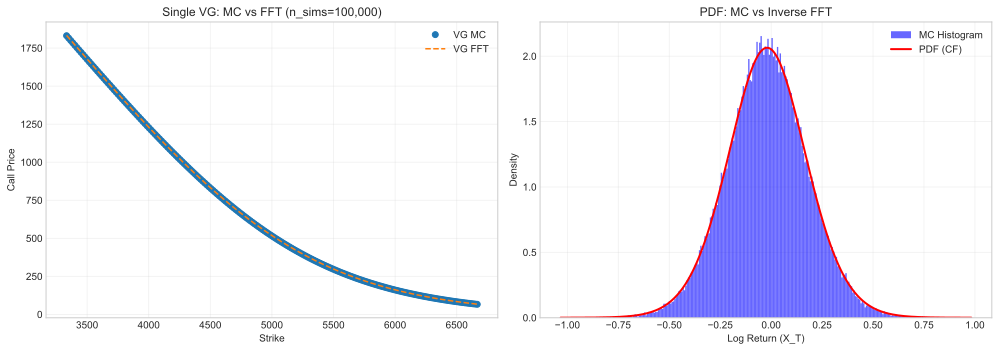

In [3]:
vg_single = vg0
n_sims_vg = 100_000

S_T_vg = monte_carlo_single_vg(T, r, S0, vg_single, n_sims=n_sims_vg)
mc_prices_vg = np.array([np.exp(-r * T) * np.maximum(S_T_vg - K, 0.0).mean() for K in strikes])
fft_prices_vg = fft_call_price(strikes, T, r, S0, lambda u: vg_cf(u, T, vg_single))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(strikes, mc_prices_vg, "o", label="VG MC")
axes[0].plot(strikes, fft_prices_vg, "--", label="VG FFT")
axes[0].set_xlabel("Strike")
axes[0].set_ylabel("Call Price")
axes[0].set_title(f"Single VG: MC vs FFT (n_sims={n_sims_vg:,})")
axes[0].grid(alpha=0.3)
axes[0].legend()

log_returns_mc = np.log(S_T_vg / S0) - r * T
x_pdf = np.linspace(log_returns_mc.min(), log_returns_mc.max(), 300)
compensator_vg = np.real(np.log(vg_cf(np.array([-1j]), T, vg_single)[0]))
pdf_fft = pdf_from_cf(x_pdf + compensator_vg, lambda u: vg_cf(u, T, vg_single))
axes[1].hist(log_returns_mc, bins=300, density=True, alpha=0.6, label="MC Histogram", color="blue")
axes[1].plot(x_pdf, pdf_fft, "r-", linewidth=2, label="PDF (CF)")
axes[1].set(xlabel="Log Return (X_T)", ylabel="Density", title="PDF: MC vs Inverse FFT")
axes[1].legend()
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Two-State Markov VG: FFT vs Monte Carlo

Now we use the 2-state Markov chain with parameters $(\sigma_0,\nu_0,\theta_0), (\sigma_1,\nu_1,\theta_1), \lambda_{01}, \lambda_{10}, p_0$.
We compare FFT prices using the closed-form CF $\phi_X(u)$ with Monte Carlo prices from the Markov-switching simulator.

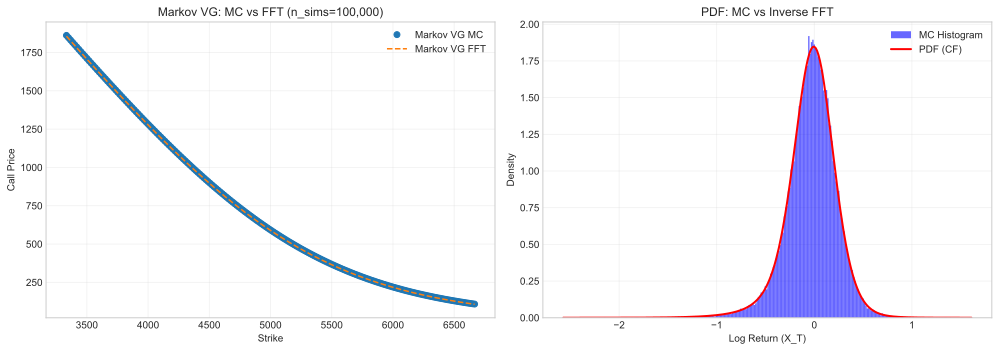

In [4]:
n_sims_markov = 100_000
S_T_markov = monte_carlo_markov_vg_numba(
    T, r, S0, vg0, vg1, lam01, lam10, p0, n_sims=n_sims_markov, n_steps=500
)

mc_prices_markov = np.array(
    [np.exp(-r * T) * np.maximum(S_T_markov - K, 0.0).mean() for K in strikes]
)
fft_prices_markov = fft_call_price(
    strikes, T, r, S0, lambda u: markov_vg_cf(u, T, vg0, vg1, lam01, lam10, p0)
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(strikes, mc_prices_markov, "o", label="Markov VG MC")
axes[0].plot(strikes, fft_prices_markov, "--", label="Markov VG FFT")
axes[0].set_xlabel("Strike")
axes[0].set_ylabel("Call Price")
axes[0].set_title(f"Markov VG: MC vs FFT (n_sims={n_sims_markov:,})")
axes[0].grid(alpha=0.3)
axes[0].legend()

log_returns_mc = np.log(S_T_markov / S0) - r * T
x_pdf = np.linspace(log_returns_mc.min(), log_returns_mc.max(), 300)
compensator_markov = np.real(
    np.log(markov_vg_cf(np.array([-1j]), T, vg0, vg1, lam01, lam10, p0)[0])
)
pdf_fft = pdf_from_cf(
    x_pdf + compensator_markov, lambda u: markov_vg_cf(u, T, vg0, vg1, lam01, lam10, p0)
)
axes[1].hist(log_returns_mc, bins=300, density=True, alpha=0.6, label="MC Histogram", color="blue")
axes[1].plot(x_pdf, pdf_fft, "r-", linewidth=2, label="PDF (CF)")
axes[1].set_xlabel("Log Return (X_T)")
axes[1].set_ylabel("Density")
axes[1].set_title("PDF: MC vs Inverse FFT")
axes[1].legend()
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Calibration: Fitting Models to "True" Market Data

We define hidden "true" parameters for a Markov VG model, generate option prices assuming the stock follows this model,
then fit both a single VG and a Markov VG model to these prices. For the Markov VG, we should recover parameters close to the true ones.
The single VG parameters should be somewhere between the true parameters of the two states.

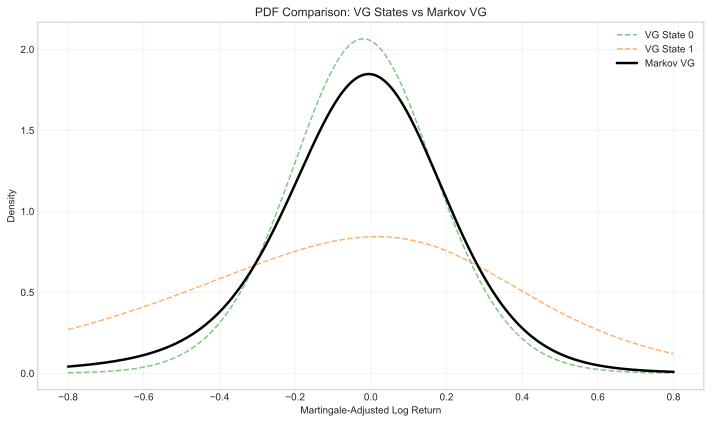

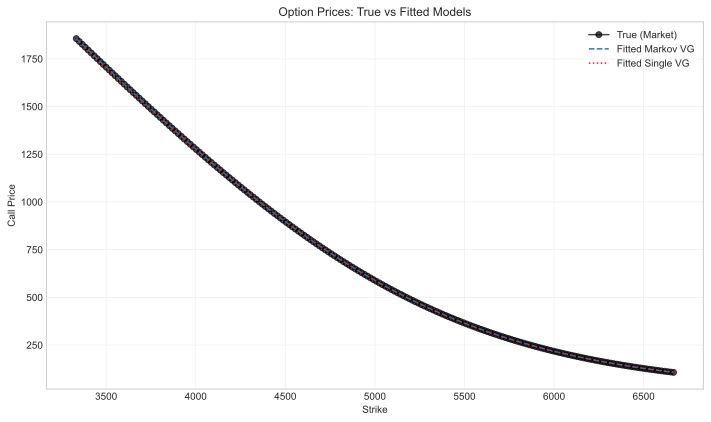

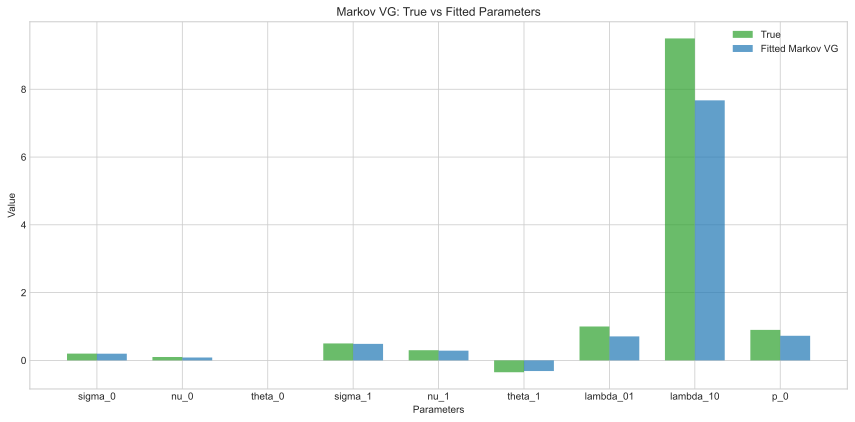

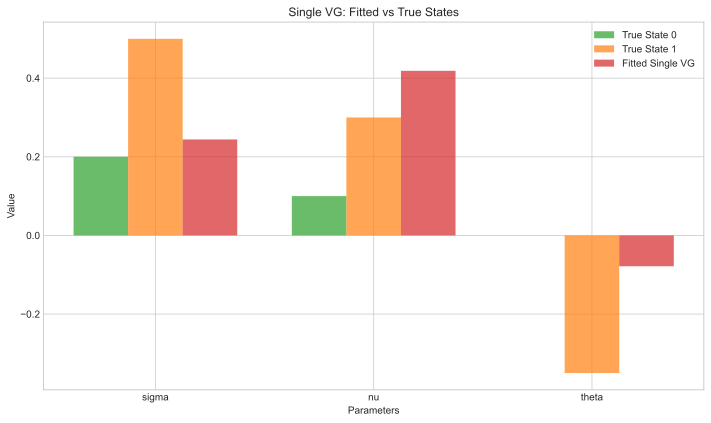

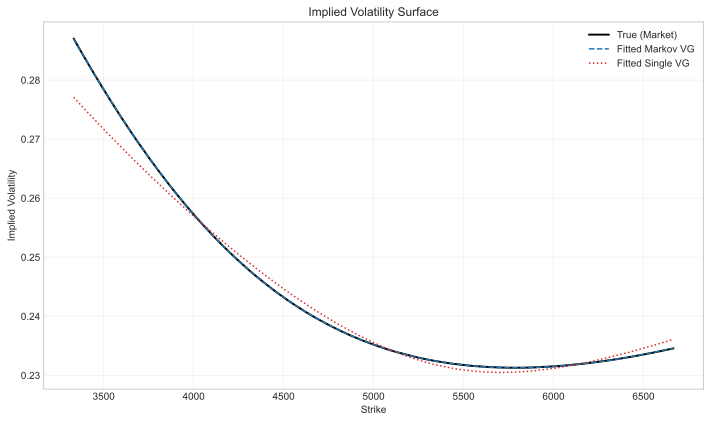

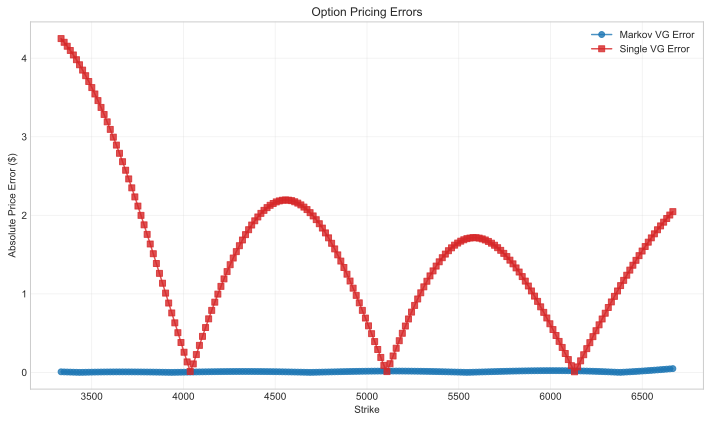

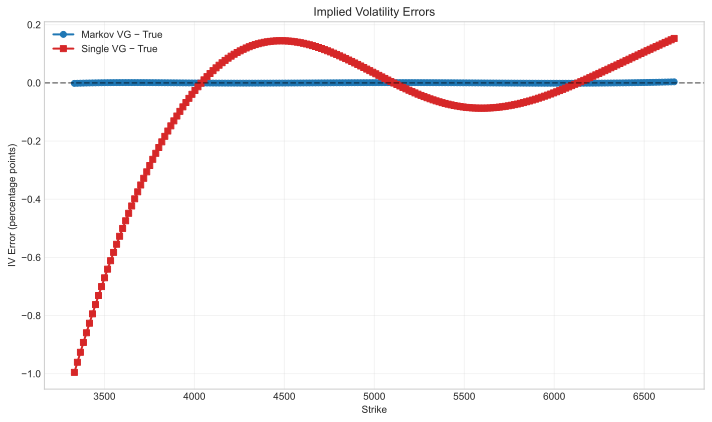

In [5]:
true_vg0 = VGParams(0.20, 0.1, 0.00)
true_vg1 = VGParams(0.50, 0.30, -0.35)
true_lam01, true_lam10, true_p0 = 1.0, 9.5, 0.9

market_strikes = strikes
cf_true = lambda u: markov_vg_cf(u, T, true_vg0, true_vg1, true_lam01, true_lam10, true_p0)
market_prices = fft_call_price(market_strikes, T, r, S0, cf_true)

# PDF comparison
x_pdf_comp = np.linspace(-0.8, 0.8, 1000)
comp_vg0 = np.real(np.log(vg_cf([-1j], T, true_vg0)[0]))
comp_vg1 = np.real(np.log(vg_cf([-1j], T, true_vg1)[0]))
comp_markov = np.real(np.log(cf_true([-1j])[0]))

plt.figure(figsize=(10, 6))
plt.plot(x_pdf_comp, pdf_from_cf(x_pdf_comp + comp_vg0, lambda u: vg_cf(u, T, true_vg0)), "--", 
         label="VG State 0", color="#2ca02c", alpha=0.6)
plt.plot(x_pdf_comp, pdf_from_cf(x_pdf_comp + comp_vg1, lambda u: vg_cf(u, T, true_vg1)), "--", 
         label="VG State 1", color="#ff7f0e", alpha=0.6)
plt.plot(x_pdf_comp, pdf_from_cf(x_pdf_comp + comp_markov, cf_true), "-", 
         label="Markov VG", color="black", linewidth=2.5)
plt.xlabel("Martingale-Adjusted Log Return"); plt.ylabel("Density")
plt.title("PDF Comparison: VG States vs Markov VG"); plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# Calibrate models
init_single = [(true_vg0.sigma + true_vg1.sigma)/2, (true_vg0.nu + true_vg1.nu)/2, (true_vg0.theta + true_vg1.theta)/2]
fit_vg = calibrate_single_vg(market_strikes, market_prices, T, r, S0, initial_params=init_single)

init_markov = [p * 0.8 for p in [true_vg0.sigma, true_vg0.nu, true_vg0.theta, true_vg1.sigma, true_vg1.nu, 
                                 true_vg1.theta, true_lam01, true_lam10, true_p0]]
fit_vg0, fit_vg1, fit_lam01, fit_lam10, fit_p0 = calibrate_markov_vg(market_strikes, market_prices, T, r, S0, 
                                                                    initial_params=init_markov)

# Price fitted models
cf_fit_single = lambda u: vg_cf(u, T, fit_vg)
cf_fit_markov = lambda u: markov_vg_cf(u, T, fit_vg0, fit_vg1, fit_lam01, fit_lam10, fit_p0)
prices_fit_single = fft_call_price(market_strikes, T, r, S0, cf_fit_single)
prices_fit_markov = fft_call_price(market_strikes, T, r, S0, cf_fit_markov)

# Option prices plot
plt.figure(figsize=(10, 6))
plt.plot(market_strikes, market_prices, "o-", label="True (Market)", color="black", alpha=0.7)
plt.plot(market_strikes, prices_fit_markov, "--", label="Fitted Markov VG", color="#1f77b4")
plt.plot(market_strikes, prices_fit_single, ":", label="Fitted Single VG", color="#d62728")
plt.xlabel("Strike"); plt.ylabel("Call Price"); plt.title("Option Prices: True vs Fitted Models")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# Parameter comparisons
param_names = ["sigma_0", "nu_0", "theta_0", "sigma_1", "nu_1", "theta_1", "lambda_01", "lambda_10", "p_0"]
true_params = [true_vg0.sigma, true_vg0.nu, true_vg0.theta, true_vg1.sigma, true_vg1.nu, true_vg1.theta, 
               true_lam01, true_lam10, true_p0]
fitted_params = [fit_vg0.sigma, fit_vg0.nu, fit_vg0.theta, fit_vg1.sigma, fit_vg1.nu, fit_vg1.theta, 
                 fit_lam01, fit_lam10, fit_p0]

x_pos = np.arange(len(param_names))
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x_pos - 0.175, true_params, 0.35, label="True", alpha=0.7, color="#2ca02c")
ax.bar(x_pos + 0.175, fitted_params, 0.35, label="Fitted Markov VG", alpha=0.7, color="#1f77b4")
ax.set_xlabel("Parameters"); ax.set_ylabel("Value"); ax.set_title("Markov VG: True vs Fitted Parameters")
ax.set_xticks(x_pos); ax.set_xticklabels(param_names); ax.legend(); plt.tight_layout(); plt.show()

# Single VG parameters
fig, ax = plt.subplots(figsize=(10, 6))
x_pos_vg = np.arange(3)
ax.bar(x_pos_vg - 0.25, [true_vg0.sigma, true_vg0.nu, true_vg0.theta], 0.25, label="True State 0", 
       alpha=0.7, color="#2ca02c")
ax.bar(x_pos_vg, [true_vg1.sigma, true_vg1.nu, true_vg1.theta], 0.25, label="True State 1", 
       alpha=0.7, color="#ff7f0e")
ax.bar(x_pos_vg + 0.25, [fit_vg.sigma, fit_vg.nu, fit_vg.theta], 0.25, label="Fitted Single VG", 
       alpha=0.7, color="#d62728")
ax.set_xlabel("Parameters"); ax.set_ylabel("Value"); ax.set_title("Single VG: Fitted vs True States")
ax.set_xticks(x_pos_vg); ax.set_xticklabels(["sigma", "nu", "theta"]); ax.legend(); plt.tight_layout(); plt.show()

# Implied volatilities
flag = np.full(len(market_strikes), "c")
iv_func = py_vollib_vectorized.implied_volatility.vectorized_implied_volatility
iv_true = iv_func(market_prices, S0, market_strikes, T, r, flag, q=0, model="black_scholes", 
                  on_error="warn", return_as="numpy")
iv_fit_markov = iv_func(prices_fit_markov, S0, market_strikes, T, r, flag, q=0, model="black_scholes", 
                        on_error="warn", return_as="numpy")
iv_fit_single = iv_func(prices_fit_single, S0, market_strikes, T, r, flag, q=0, model="black_scholes", 
                        on_error="warn", return_as="numpy")

plt.figure(figsize=(10, 6))
plt.plot(market_strikes, iv_true, "-", label="True (Market)", color="black", linewidth=2)
plt.plot(market_strikes, iv_fit_markov, "--", label="Fitted Markov VG", color="#1f77b4")
plt.plot(market_strikes, iv_fit_single, ":", label="Fitted Single VG", color="#d62728")
plt.xlabel("Strike"); plt.ylabel("Implied Volatility"); plt.title("Implied Volatility Surface")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# Pricing errors
error_markov = np.abs(prices_fit_markov - market_prices)
error_single = np.abs(prices_fit_single - market_prices)
plt.figure(figsize=(10, 6))
plt.plot(market_strikes, error_markov, "-o", label="Markov VG Error", color="#1f77b4", alpha=0.8)
plt.plot(market_strikes, error_single, "-s", label="Single VG Error", color="#d62728", alpha=0.8)
plt.xlabel("Strike"); plt.ylabel("Absolute Price Error ($)"); plt.title("Option Pricing Errors")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# IV errors
iv_error_markov = (iv_fit_markov - iv_true) * 100
iv_error_single = (iv_fit_single - iv_true) * 100
plt.figure(figsize=(10, 6))
plt.plot(market_strikes, iv_error_markov, "-o", label="Markov VG − True", color="#1f77b4", linewidth=2)
plt.plot(market_strikes, iv_error_single, "-s", label="Single VG − True", color="#d62728", linewidth=2)
plt.axhline(0, color="black", linestyle="--", alpha=0.5)
plt.xlabel("Strike"); plt.ylabel("IV Error (percentage points)"); plt.title("Implied Volatility Errors")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

## PDF Comparison: True vs Fitted Models

Compare the log-return PDFs of the true Markov VG, true VG states, fitted Markov VG, and fitted single VG.

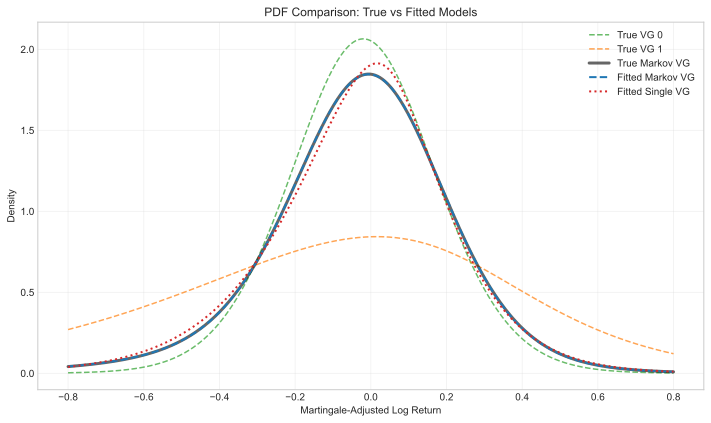

In [6]:
x_pdf_fit = np.linspace(-0.8, 0.8, 500)
comp_true_markov = np.real(np.log(cf_true(np.array([-1j]))[0]))
comp_true_vg0 = np.real(np.log(vg_cf(np.array([-1j]), T, true_vg0)[0]))
comp_true_vg1 = np.real(np.log(vg_cf(np.array([-1j]), T, true_vg1)[0]))
comp_fit_markov = np.real(np.log(cf_fit_markov(np.array([-1j]))[0]))
comp_fit_single = np.real(np.log(cf_fit_single(np.array([-1j]))[0]))

plt.figure(figsize=(10, 6))
plt.plot(x_pdf_fit, pdf_from_cf(x_pdf_fit + comp_true_vg0, lambda u: vg_cf(u, T, true_vg0)), "--", 
         label="True VG 0", color="#2ca02c", alpha=0.7)
plt.plot(x_pdf_fit, pdf_from_cf(x_pdf_fit + comp_true_vg1, lambda u: vg_cf(u, T, true_vg1)), "--", 
         label="True VG 1", color="#ff7f0e", alpha=0.7)
plt.plot(x_pdf_fit, pdf_from_cf(x_pdf_fit + comp_true_markov, cf_true), "-", 
         label="True Markov VG", color="black", linewidth=3, alpha=0.6)
plt.plot(x_pdf_fit, pdf_from_cf(x_pdf_fit + comp_fit_markov, cf_fit_markov), "--", 
         label="Fitted Markov VG", color="#1f77b4", linewidth=2)
plt.plot(x_pdf_fit, pdf_from_cf(x_pdf_fit + comp_fit_single, cf_fit_single), ":", 
         label="Fitted Single VG", color="#d62728", linewidth=2)
plt.xlabel("Martingale-Adjusted Log Return"); plt.ylabel("Density")
plt.title("PDF Comparison: True vs Fitted Models")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()